In [19]:
import torch
import arviz as az
from scipy.optimize import curve_fit
from bokeh.plotting import figure, show,output_file, save
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Spectral
from bokeh.models import Slope, Div
from bokeh.io import curdoc,output_notebook,export_png
from bokeh.layouts import column,gridplot
#from print_versions import print_versions
from sklearn.metrics import r2_score
from seaborn import clustermap
from bokeh.models import Band, ColumnDataSource
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [20]:
train=pd.read_excel(r"../data/chem_train.xlsx")
test=pd.read_excel(r"../data/chem_test.xlsx")

In [21]:
train_predict=train.copy()
train=train.loc[(train.corrected_week>0)&(train.corrected_week<53),:]
test_predict=test.copy()
test=test.loc[(test.corrected_week>0)&(test.corrected_week<53),:]

In [22]:
gpr=torch.load("../models/no2_seasonality",weights_only=False,map_location='cuda')

In [23]:
gpr_bc=torch.load("../models/nox_seasonality",weights_only=False,map_location='cuda')

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
gpr

GPRegression(
  (kernel): RBF()
)

In [26]:
linmod_np=np.linspace(0,52,800)
theta=linmod_np/linmod_np.max()*2*np.pi
lindmod_df=pd.DataFrame([np.cos(theta),np.sin(theta)])
linmod=torch.from_numpy(lindmod_df.values.astype("float64").T).to(device)
pm25_model,pm25_model_std=gpr(linmod,full_cov=True)


pm25_model_np,pm25_model_std_np=pm25_model.cpu().detach().numpy().copy(),pm25_model_std.diag().sqrt().cpu().detach().numpy().copy()

lower1 = pm25_model_np - pm25_model_std_np
upper1 = pm25_model_np + pm25_model_std_np
data1=pd.DataFrame([linmod_np,lower1,upper1],index=["corrected_week","lower","upper"]).T
data1 = ColumnDataSource(data1.reset_index())

In [27]:

bc_model,bc_model_std=gpr_bc(linmod, full_cov=True)
bc_model_np,bc_model_std_np=bc_model.cpu().detach().numpy().copy(),bc_model_std.diag().sqrt().cpu().detach().numpy().copy()

lower1_bc = bc_model_np - bc_model_std_np
upper1_bc = bc_model_np + bc_model_std_np
data1_bc=pd.DataFrame([linmod_np,lower1_bc,upper1_bc],index=["corrected_week","lower_bc","upper_bc"]).T
data1_bc = ColumnDataSource(data1_bc.reset_index())

In [28]:
train_predict

Unnamed: 0.1  cpnr  Unnamed: 0  maalnr  constrution_year   Area  \
0               0   104       246.0     1.0            1970.0  156.0   
1               1   104       248.0     3.0            1970.0  156.0   
2               2   104       248.0     3.0            1970.0  156.0   
3               3   257       621.0     1.0            1996.0  110.0   
4               4   257       623.0     3.0            1996.0  110.0   
..            ...   ...         ...     ...               ...    ...   
949             0   274       666.0     3.0            1962.0   75.0   
950             0   427      1052.0     2.0            1959.7   99.1   
951             0   119       284.0     1.0            1890.0  205.0   
952             0   119       286.0     3.0            1890.0  205.0   
953             0   335       809.0     1.0            1950.2  110.3   

     floor_level  powerplant     road  motorway  ...  gastove  fireplace  \
0            0.0         0.0  17893.5      10.0  ...      2.0      150.0   
1            0.0         0.0  17893.5      10.0  ...      0.0      220.0   
2            0.0         0.0  17893.5      10.0  ...      0.0      220.0   
3            0.0         0.0   4280.3      10.8  ...      5.0       90.0   
4            0.0         0.0   4280.3      10.8  ...     18.0      190.0   
..           ...         ...      ...       ...  ...      ...        ...   
949          1.0         7.1  15685.2     560.9  ...    300.0        0.0   
950          0.0       121.6  27399.0    1828.9  ...      0.0       15.0   
951          0.0         0.0   2756.2       0.0  ...      0.0      240.0   
952          0.0         0.0   2756.2       0.0  ...      0.0      245.0   
953          0.0       183.2  24299.7    1964.6  ...    255.0        0.0   

     visit   no2   nox  formaldehyd    acetald    acetone  sample_time  \
0        1   7.8  21.3    25.900000  23.300000  54.100000           76   
1        3   6.5  14.6    26.498496   2.625317   6.299715           72   
2        4   4.6   4.5    31.393703   2.727302   7.705821           71   
3        1   5.5   5.8    26.783053  12.992725  16.256963           70   
4        3   5.8   NaN    15.803975   1.531092   1.307573           71   
..     ...   ...   ...          ...        ...        ...          ...   
949      3  10.9  18.5    22.992311   2.211332   5.277120           71   
950      2  13.6  65.4    22.928374   1.834360   1.809277           91   
951      1   5.7  22.2     9.300000   8.300000   8.900000           72   
952      3   5.3  12.2    11.530052   8.254482   5.024362           88   
953      1  11.6  51.8    13.400347  10.737955  11.374607           71   

     corrected_week  
0         46.000000  
1         43.857143  
2         16.714286  
3         31.142857  
4         27.428571  
..              ...  
949      -17.585714  
950       -8.157143  
951       -4.014286  
952       -4.728571  
953       -1.871429  

[954 rows x 28 columns]

In [19]:
def roll_week(data,resolution,week,particle):
    mean=[]
    std=[]
    x=np.linspace(0,53,resolution,endpoint=True)
    sort=data.sort_values("corrected_week")
    list_std=[particle+"_std" for particle in particle]
    for i in x:
        mean.append(sort.loc[(i-week<sort.corrected_week)&(i+week>sort.corrected_week),particle].mean())
        std.append(sort.loc[(i-week<sort.corrected_week)&(i+week>sort.corrected_week),particle].std())
    mean_1,std_1=pd.DataFrame(mean,index=x),pd.DataFrame(std,index=x)
    std_1.columns=std_1.columns+"_std"
    data=pd.concat([mean_1,std_1],axis=1)
    return data.set_index(x)

In [20]:
resolution=500
week_averange=2
mean=roll_week(train_predict,resolution,week_averange,["no2","nox"])
mean_test=roll_week(test_predict,resolution,week_averange,["no2","nox"])
x=np.linspace(0,53,resolution,endpoint=True)
theta=x/x.max()*2*np.pi
lindmod_df=pd.DataFrame([np.cos(theta),np.sin(theta)])
linmod=torch.from_numpy(lindmod_df.values.astype("float64").T).to(device)
nox=gpr_bc(linmod)[0].cpu().detach().numpy()
no2=gpr(linmod)[0].cpu().detach().numpy()

In [21]:
lower1_std = mean.no2 - mean.no2_std
upper1_std = mean.no2 + mean.no2_std
lower1_bc_std  = mean.nox - mean.nox_std
upper1_bc_std  = mean.nox + mean.nox_std
mean["lower1_std_pm"]=lower1_std
mean["upper1_std_pm"]=upper1_std
mean["lower1_std_bc"]=lower1_bc_std
mean["upper1_std_bc"]=upper1_bc_std

mean=mean.dropna()
mean1 = ColumnDataSource(mean.reset_index())

In [22]:
train.loc[:,"theta"]=train.corrected_week/train.corrected_week.max()*2*np.pi
train.loc[:,"cos_theta"]=np.cos(train.corrected_week/train.corrected_week.max()*2*np.pi)
train.loc[:,"sin_theta"]=np.sin(train.corrected_week/train.corrected_week.max()*2*np.pi)

In [23]:
r2_no2_test,r2_nox_test=r2_score(mean_test.no2,no2),r2_score(mean_test.nox,nox)
r2_no2,r2_nox=r2_score(mean.no2,no2),r2_score(mean.nox,nox)

In [24]:
output_notebook()
TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,examine,help"

Loading BokehJS ...

In [25]:
p = figure(x_range=(0, 53),y_range=(5, 20));
p.title.text = r" $$NO_2$$ seasonality";

p.xgrid.grid_line_color=None;
p.ygrid.grid_line_alpha=0.5;
p.line(mean_test.index, mean_test.no2, line_width=3,color="orange",legend_label="Test roll mean R2 "+str(round(r2_no2_test,2)));
p.line(mean.index, mean.no2, line_width=3,color="green",legend_label="Train roll mean R2 "+str(round(r2_no2,2)));
p.line(linmod_np, pm25_model_np, line_width=3,color="red",legend_label="Gaussion model");
p.scatter(train.corrected_week, y=train.no2, color="blue", marker="dot", size=20, alpha=0.7,legend_label="Raw points");
band = Band(base="index", lower="lower1_std_pm", upper="upper1_std_pm",source=mean1, fill_color="red", line_color="black",fill_alpha=0.2);
band1 = Band(base="corrected_week", lower="lower", upper="upper",source=data1,fill_alpha=0.5, fill_color="blue", line_color="black");
p.yaxis.axis_label_orientation  = 0
p.add_layout(band);
p.add_layout(band1);
p.xaxis.axis_label = r'$$ Week \ of \ the \ year$$';
p.yaxis.axis_label = r'$$ \frac{\mu g}{m^3} $$';
p1 = figure(x_range=(0, 53),y_range=(0, 70));
p1.title.text = r" $$NO_x$$ seasonality";
p1.xgrid.grid_line_color=None;
p1.ygrid.grid_line_alpha=0.5;
p1.line(mean.index, mean.nox, line_width=3,color="green",legend_label="Train roll mean R2 "+str(round(r2_nox,2)));
p1.line(mean_test.index, mean_test.nox, line_width=3,color="orange",legend_label="Test roll mean R2 "+str(round(r2_nox_test,2)));

p1.line(linmod_np, bc_model_np, line_width=3,color="red",legend_label="Gaussion model");
p1.scatter(train.corrected_week, y=train.nox, color="blue", marker="dot", size=20, alpha=0.7,legend_label="Raw points");
band2 = Band(base="corrected_week", lower="lower_bc", upper="upper_bc",source=data1_bc, fill_color="blue", line_color="black",fill_alpha=0.5);
band3 = Band(base="index", lower="lower1_std_bc", upper="upper1_std_bc",source=mean1, fill_color="red", line_color="black",fill_alpha=0.2);
p1.add_layout(band3);
p1.add_layout(band2);
p1.yaxis.axis_label_orientation  = 0
p1.xaxis.axis_label = r'$$Week \ of \ the \ year$$';
p1.yaxis.axis_label = r'$$ \frac{\mu g}{m^3} $$';
p1.legend.title_text_font_size = "25px";
p.legend.title_text_font_size = "25px";
p.xaxis.axis_label_text_font_size = "16px";
p.yaxis.axis_label_text_font_size = "16px";
p1.xaxis.axis_label_text_font_size = "16px";
p1.yaxis.axis_label_text_font_size = "16px";
p1.yaxis.axis_label_text_font_style = "bold";
p1.xaxis.axis_label_text_font_style = "bold";
p.yaxis.axis_label_text_font_style = "bold";
p.xaxis.axis_label_text_font_style = "bold";
p.legend.label_text_font_size = '15pt'
p1.legend.label_text_font_size = '15pt'
p.title.text_font_size = '13pt'
p1.title.text_font_size = '13pt'
grid =  gridplot([[p, p1]], width=500, height=500);

show(column(grid));

In [45]:
export_png(grid, filename="plot.png")

RuntimeError: To use bokeh.io image export functions you need selenium ('conda install selenium' or 'pip install selenium')

In [30]:
mean_test.no2

0.000000     8.000000
0.106212     7.500000
0.212425     7.500000
0.318637     7.666667
0.424850     7.666667
               ...   
52.575150    7.666667
52.681363    7.666667
52.787575    7.484615
52.893788    7.453846
53.000000    7.453846
Name: no2, Length: 500, dtype: float64

In [31]:

r2_score(test.no2,test_2),r2_score(test.nox,test_1)

NameError: name 'test_2' is not defined

In [32]:
r2_score(test.no2,test_2),r2_score(test.nox,test_1)

NameError: name 'test_2' is not defined

In [33]:
pyro_data=az.from_json("../Arviz_stats/mcmc_nox_seasonality.json")

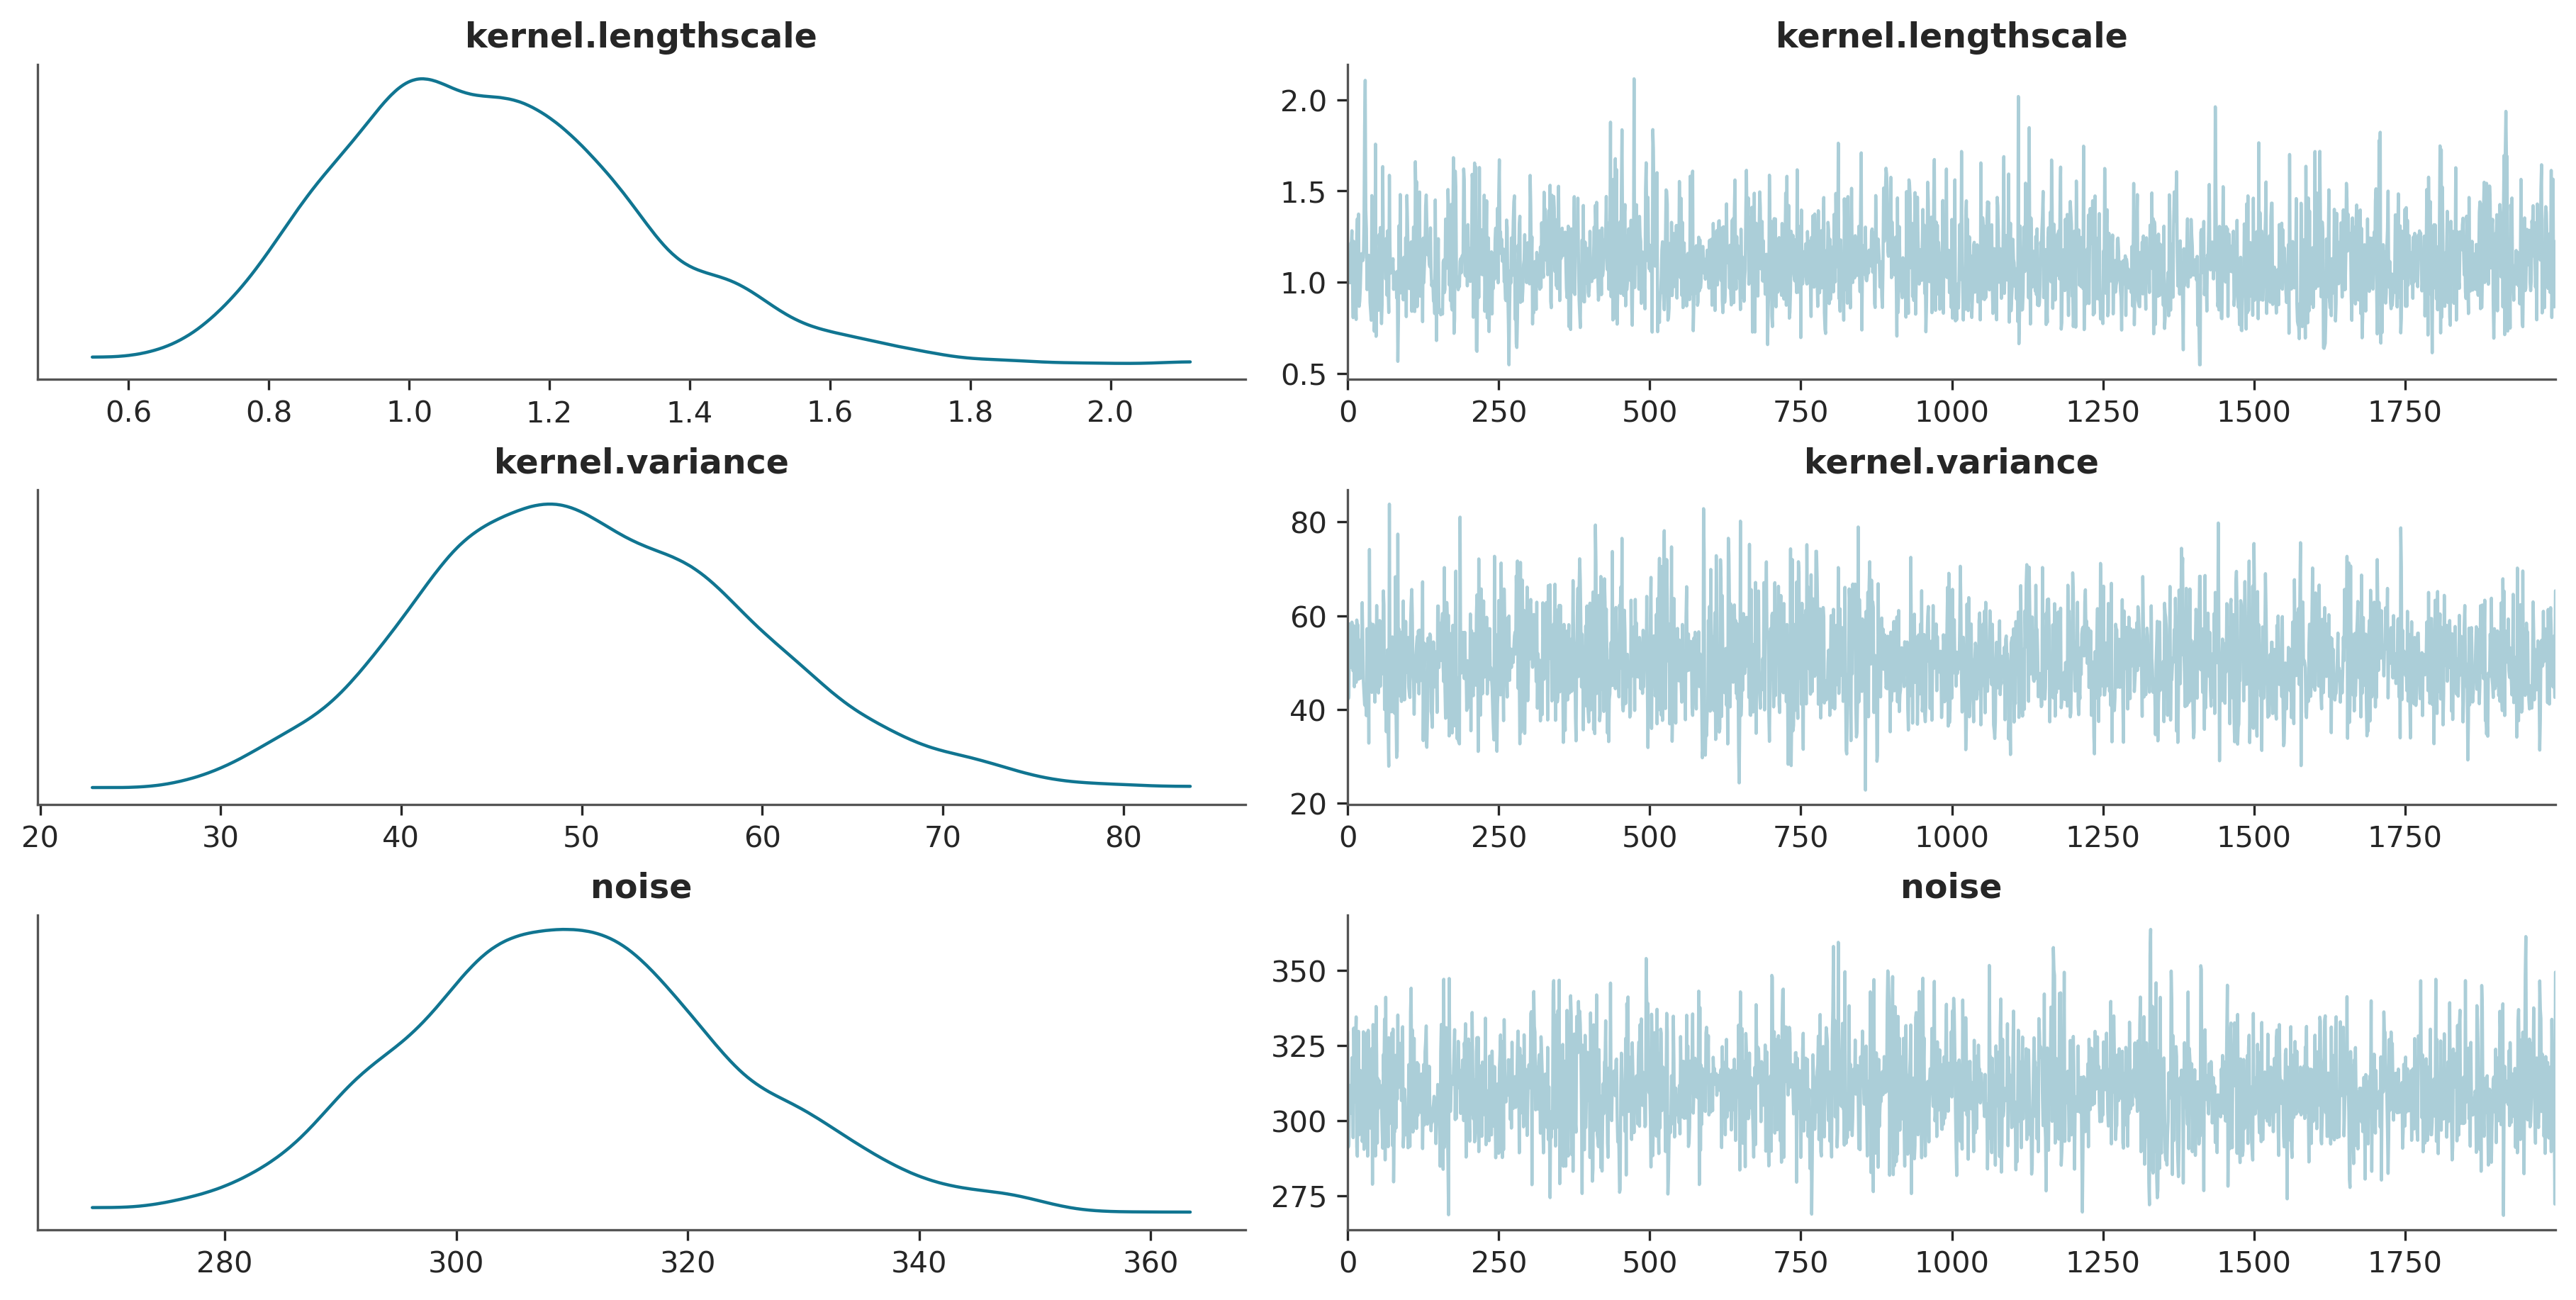

In [34]:
az.style.use("arviz-doc")

ax = az.plot_trace(pyro_data)

In [35]:
ax = az.plot_density(
    pyro_data,backend='bokeh'
)

In [36]:
az.plot_pair(pyro_data,kind='kde',divergences=True,textsize=18)


array([[<Axes: ylabel='kernel.variance'>, <Axes: >],
       [<Axes: xlabel='kernel.lengthscale', ylabel='noise'>,
        <Axes: xlabel='kernel.variance'>]], dtype=object)

In [37]:
pyro_data_bc=az.from_json("../Arviz_stats/mcmc_nox_seasonality.json")

In [38]:
az.style.use("arviz-doc")

ax = az.plot_trace(pyro_data_bc,backend='bokeh')

In [39]:
ax = az.plot_density(
    [pyro_data_bc],
    shade=0.1,backend='bokeh'
)

In [40]:
az.plot_pair(pyro_data_bc,kind='kde',divergences=True,textsize=18)


array([[<Axes: ylabel='kernel.variance'>, <Axes: >],
       [<Axes: xlabel='kernel.lengthscale', ylabel='noise'>,
        <Axes: xlabel='kernel.variance'>]], dtype=object)